# 作業 : (Kaggle)鐵達尼生存預測
***
- 分數以網站評分結果為準, 請同學實際將提交檔(*.csv)上傳試試看  
https://www.kaggle.com/c/titanic/submit

# [作業目標]
- 試著模仿範例寫法, 在鐵達尼生存預測中, 觀察觀查混合泛化 (Blending) 的寫法與效果

# [作業重點]
- 觀察混合泛化的準確度 (In[14]), 是否比單一模型準確度為高 (In[11~13])  
- 除了我們的權重, 同學也可以試著自行調整權重 (注意:權重和=1), 看看有什麼影響
- Hint : 除了權重, 分類預測的調整, 還可以調整什麼地方?

In [45]:
# 做完特徵工程前的所有準備 (與前範例相同)
import pandas as pd
import numpy as np
import copy, time
import warnings
warnings.filterwarnings('ignore')
from IPython.display import display
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score

data_path = 'data/'
df_train = pd.read_csv(data_path + 'titanic_train.csv')
df_test = pd.read_csv(data_path + 'titanic_test.csv')
df_train = df_train.append(df_train)
train_Y = df_train['Survived']
ids = df_test['PassengerId']
df_train = df_train.drop(['PassengerId'] , axis=1)
df_test = df_test.drop(['PassengerId'] , axis=1)
df = pd.concat([df_train,df_test])
df

,Age,Cabin,Embarked,Fare,Name,Parch,Pclass,Sex,SibSp,Survived,Ticket
0,22.0,NaN,S,7.2500,"Braund, Mr. Owen Harris",0,3,male,1,0.0,A/5 21171
1,38.0,C85,C,71.2833,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,1,female,1,1.0,PC 17599
2,26.0,NaN,S,7.9250,"Heikkinen, Miss. Laina",0,3,female,0,1.0,STON/O2. 3101282
3,35.0,C123,S,53.1000,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,1,female,1,1.0,113803
4,35.0,NaN,S,8.0500,"Allen, Mr. William Henry",0,3,male,0,0.0,373450
5,NaN,NaN,Q,8.4583,"Moran, Mr. James",0,3,male,0,0.0,330877
6,54.0,E46,S,51.8625,"McCarthy, Mr. Timothy J",0,1,male,0,0.0,17463
7,2.0,NaN,S,21.0750,"Palsson, Master. Gosta Leonard",1,3,male,3,0.0,349909
8,27.0,NaN,S,11.1333,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",2,3,female,0,1.0,347742
9,14.0,NaN,C,30.0708,"Nasser, Mrs. Nicholas (Adele Achem)",0,2,female,1,1.0,237736


In [46]:
# 檢查 DataFrame 空缺值的狀態
def na_check(df_data):
    data_na = (df_data.isnull().sum() / len(df_data)) * 100
    data_na = data_na.drop(data_na[data_na == 0].index).sort_values(ascending=False)
    missing_data = pd.DataFrame({'Missing Ratio' :data_na})
    display(missing_data.head(10))
na_check(df)

,Missing Ratio
Cabin,77.318182
Age,20.000000
Survived,19.000000
Embarked,0.181818
Fare,0.045455


In [47]:
# 以下 In[3]~In[10] 只是鐵達尼預測中的一組特徵工程, 並以此組特徵工程跑參數, 若更換其他特徵工程, In[10]的參數需要重新跑
# Sex : 直接轉男 0 女 1
df["Sex"] = df["Sex"].map({"male": 0, "female":1})
# Fare : 用 log 去偏態, 0 則直接取 0
df["Fare"] = df["Fare"].map(lambda i: np.log(i) if i > 0 else 0)
# Age : 缺值用中位數補
df["Age"] = df["Age"].fillna(df['Age'].median())

In [48]:
# Title 的 特徵工程 : 將各種頭銜按照類型分類, 最後取 One Hot
df_title = [i.split(",")[1].split(".")[0].strip() for i in df["Name"]]
df["Title"] = pd.Series(df_title)
df["Title"] = df["Title"].replace(['Lady', 'the Countess','Countess','Capt', 'Col','Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')
df["Title"] = df["Title"].map({"Master":0, "Miss":1, "Ms" : 1 , "Mme":1, "Mlle":1, "Mrs":1, "Mr":2, "Rare":3})
df["Title"] = df["Title"].astype(int)
df = pd.get_dummies(df, columns = ["Title"])

In [49]:
# 新建:家庭大小 (Fsize)特徵, 並依照大小分別建獨立欄位
df["Fsize"] = df["SibSp"] + df["Parch"] + 1
df['Single'] = df['Fsize'].map(lambda s: 1 if s == 1 else 0)
df['SmallF'] = df['Fsize'].map(lambda s: 1 if  s == 2  else 0)
df['MedF'] = df['Fsize'].map(lambda s: 1 if 3 <= s <= 4 else 0)
df['LargeF'] = df['Fsize'].map(lambda s: 1 if s >= 5 else 0)

In [50]:
# Ticket : 如果不只是數字-取第一個空白之前的字串(去除'.'與'/'), 如果只是數字-設為'X', 最後再取 One Hot
Ticket = []
for i in list(df.Ticket):
    if not i.isdigit() :
        Ticket.append(i.replace(".","").replace("/","").strip().split(' ')[0])
    else:
        Ticket.append("X")        
df["Ticket"] = Ticket
df = pd.get_dummies(df, columns = ["Ticket"], prefix="T")

In [51]:
# Cabib 依照第一碼分類, 再取 One Hot
df["Cabin"] = pd.Series([i[0] if not pd.isnull(i) else 'X' for i in df['Cabin'] ])
df = pd.get_dummies(df, columns = ["Cabin"], prefix="Cabin")

In [52]:
# Embarked, Pclass 取 One Hot
df = pd.get_dummies(df, columns = ["Embarked"], prefix="Em")
df["Pclass"] = df["Pclass"].astype("category")
df = pd.get_dummies(df, columns = ["Pclass"], prefix="Pc")

# 捨棄 Name 欄位
df.drop(labels = ["Name"], axis = 1, inplace = True)

In [53]:
# 確認缺值 與 目前的資料表內容
na_check(df)
df.head()

,Missing Ratio
Survived,19.0


,Age,Fare,Parch,Sex,SibSp,Survived,Title_0,Title_1,Title_2,Title_3,...,Cabin_F,Cabin_G,Cabin_T,Cabin_X,Em_C,Em_Q,Em_S,Pc_1,Pc_2,Pc_3
0,22.0,1.981001,0,0,1,0.0,0,0,1,0,...,0,0,0,1,0,0,1,0,0,1
1,38.0,4.266662,0,1,1,1.0,0,1,0,0,...,0,0,0,0,1,0,0,1,0,0
2,26.0,2.070022,0,1,0,1.0,0,1,0,0,...,0,0,0,1,0,0,1,0,0,1
3,35.0,3.972177,0,1,1,1.0,0,1,0,0,...,0,0,0,0,0,0,1,1,0,0
4,35.0,2.085672,0,0,0,0.0,0,0,1,0,...,0,0,0,1,0,0,1,0,0,1


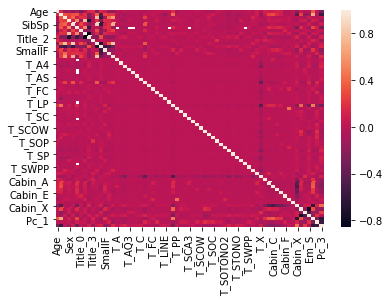

['Fare', 'Sex', 'Survived', 'Title_1', 'Title_2', 'Single', 'Cabin_X', 'Pc_1', 'Pc_3']
['Fare', 'Sex', 'Title_1', 'Title_2', 'Single', 'Cabin_X', 'Pc_1', 'Pc_3']


In [54]:
import seaborn as sns
import matplotlib.pyplot as plt
corr = df.corr()
sns.heatmap(corr)
plt.show()

# 篩選相關係數1
high_list = list(corr[(corr['Survived']>0.2) | (corr['Survived']<-0.2)].index)
print(high_list)
high_list.pop(2)
print(high_list)

In [55]:
# 將資料最大最小化
df = MinMaxScaler().fit_transform(df[high_list])
# 將前述轉換完畢資料 df , 重新切成 train_X, test_X
train_num = train_Y.shape[0]
print(train_num)
train_X = df[:train_num]
test_X = df[train_num:]

# 使用三種模型 : 邏輯斯迴歸 / 梯度提升機 / 隨機森林, 參數使用 Random Search 尋找
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier

lr = LogisticRegression(tol=0.001, 
                        penalty='l2', 
                        fit_intercept=True, 
                        C=1.0)

gdbt = GradientBoostingClassifier(tol=100, 
                                  subsample=0.75, 
                                  n_estimators=250, 
                                  max_features=8,
                                  max_depth=6, 
                                  learning_rate=0.03)

rf = RandomForestClassifier(n_estimators=100, 
                            min_samples_split=2, 
                            min_samples_leaf=1, 
                            max_features='sqrt', 
                            max_depth=6, 
                            bootstrap=True)

1782


In [56]:
# 線性迴歸預測檔 (結果有部分隨機, 請以 Kaggle 計算的得分為準, 以下模型同理)
lr.fit(train_X, train_Y)
lr_pred = lr.predict_proba(test_X)[:,1]

print(cross_val_score(lr, train_X, train_Y, cv=5, scoring='accuracy').mean())


sub = pd.DataFrame({'PassengerId': ids, 'Survived': lr_pred})
sub['Survived'] = sub['Survived'].map(lambda x:1 if x>0.5 else 0) 
sub.to_csv('titanic_lr.csv', index=False) 

0.7839353104748783


In [57]:
# 梯度提升機預測檔 
gdbt.fit(train_X, train_Y)
gdbt_pred = gdbt.predict_proba(test_X)[:,1]

print(cross_val_score(gdbt, train_X, train_Y, cv=5, scoring='accuracy').mean())

sub = pd.DataFrame({'PassengerId': ids, 'Survived': gdbt_pred})
sub['Survived'] = sub['Survived'].map(lambda x:1 if x>0.5 else 0) 
sub.to_csv('titanic_gdbt.csv', index=False)

0.9090828912669673


In [58]:
# 隨機森林預測檔
rf.fit(train_X, train_Y)
rf_pred = rf.predict_proba(test_X)[:,1]

print(cross_val_score(rf, train_X, train_Y, cv=5, scoring='accuracy').mean())

sub = pd.DataFrame({'PassengerId': ids, 'Survived': rf_pred})
sub['Survived'] = sub['Survived'].map(lambda x:1 if x>0.5 else 0) 
sub.to_csv('titanic_rf.csv', index=False)

0.8507313012243986


# 作業
* 雖然同樣是混合泛化，分類預測其實與回歸預測有相當多的差異性，
因為鐵達尼預測的結果是 '生存/死亡'，輸出不是 0 就是 1  
因此要用權重混合時，需要以以機率的形式混合，因此我們在作業前幾格當中，先幫各位同學把預測值寫成了機率的形式  
(請同學把下列程式完成，並將結果提交到 Kaggle 網站看看結果)

* 但是光是這樣，分類問題的混合泛化就能比單模預測還要好嗎?  
已經快要期中考了，這裡請同學挑戰看看，還有沒有什麼方法可以改進混合泛化的結果?

In [59]:
# 混合泛化預測檔 

blending_pred = lr_pred*0.3  + gdbt_pred*0.4 + rf_pred*0.3
sub = pd.DataFrame({'PassengerId': ids, 'Survived': blending_pred})
sub['Survived'] = sub['Survived'].map(lambda x:1 if x>0.5 else 0) 
sub.to_csv('titanic_blending.csv', index=False)